In [1]:
### SKRIPT BY THOMAS BRIAN WINKLER
### PART OF THE ARTICLE "ENEGETICS AND DYNAMICS OF A STABLE BLOCH POINT" by Winkler et al. (2023)
from magnum import *
from math import *
import numpy as np
import random
import os.path
import os
import time
import sys
import re
import matplotlib.pyplot as plt
%matplotlib inline

[   INFO] - Imported FFTW wisdom from file
[   INFO] - ----------------------------------------------------------------------
[   INFO] - MicMag 2.0rc0
[   INFO] - Copyright (C) 2012 - 2023 by the MicroMagnum team and the MicMag2 contributors.
[   INFO] - This program comes with ABSOLUTELY NO WARRANTY.
[   INFO] - This is free software, and you are welcome to redistribute it under
[   INFO] - certain conditions; see the file COPYING in the distribution package.
[   INFO] - ----------------------------------------------------------------------
[   INFO] - FFTW using 1 threads from now on
[   INFO] - CUDA GPU support: yes


In [5]:
def calc(nt, system, sample):
    nar = 100
    naz1 = 30
    naz2 = 20
    a=0.4679*1e-09  # lattice constant of FeGe in m
    t=(naz1+naz2)*a  #total thickness in [m]
    r=nar*a       #radius in [m]
    dia=2*r       #diameter in [m]  
    d = a*(naz1+naz2)/nt  #MM mesh size in [m] 
    print("d, ", d)
    nmmz = nt             # number of MM cells in z-direction
    nmm =int(round(dia/d)) # number of MM cells in x- and y-direction
    
    mu0 = 4*np.pi*1e-7   #mu0
    alpha = 0.28         #damping constant
    D = 1.58*1e-3          #DMI [J/m**2]
    A =  8.78*1e-12         #Exchange constant in [J/m]
    Ms=0.384*1e6
    mu=Ms*a**3            #magnetic moment (for HB)
    J= 2*A*a
    DISK = Material({
    'id': 'DISK',
    'Ms': Ms,
    'alpha': alpha,
    'A': A,
    'axis1': (0,0,1),
    'axis2': (0,1,0),
    'k_uniaxial': 0.0,
    'k_cubic': 0.0,
    'l':a,
    'mu':mu,
    'J':J})

    mesh = RectangularMesh((nmm, nmm, nmmz), (d, d, d))
    mesh_core = RectangularMesh((4,4,4), (d,d,d))
    if sample == "rectangular":
        disk = Cuboid((0,0,0), (nmm*d,nmm*d,nmmz*d))
    if sample == "cylindrical":
        disk = Cylinder((nmm*d/2, nmm*d/2,0.0),(nmm*d/2, nmm*d/2,nmmz*d), nmm*d/2)
    disk_core = Cuboid((0,0,0),(4*d, 4*d, 4*d))
    world = World(mesh, Body("disk", DISK, disk))
    world_core = World(mesh_core, Body("disk_core", DISK, disk_core))
    solver = create_solver(world, module_list =[StrayField, ExchangeField,  DMIField],
                           finescale = False,  log=False, do_precess = True) # finescale sets either MM (False) or HB mode (True).
    solver_core = create_solver(world_core, module_list =[StrayField, ExchangeField,  DMIField],
                           finescale = False,  log=False, do_precess = True) # finescale sets either MM (False) or HB mode (True).
    
    folder = system+"/MM_"+sample+"/"

    def fillDMIx(field, pos):
        x,y,z = pos
        if z<(naz1*a):
            return (-D, 0, 0)
        else:
            return (D, 0, 0)

    def fillDMIy(field, pos):
        x,y,z = pos
        if z<(naz1*a):
            return (0, -D, 0)
        else:
            return (0, D, 0)

    def fillDMIz(field, pos):
        x,y,z = pos
        if z<(naz1*a):
            return (0,0, 0)
        else:
            return (0, 0, 0)
    def fillDMIx_core(field, pos):
        x,y,z = pos
        if z<(2*d):
            return (-D, 0, 0)
        else:
            return (D, 0, 0)

    def fillDMIy_core(field, pos):
        x,y,z = pos
        if z<(2*d):
            return (0, -D, 0)
        else:
            return (0, D, 0)

    def fillDMIz_core(field, pos):
        x,y,z = pos
        if z<(2*d):
            return (0,0, 0)
        else:
            return (0, 0, 0)
        
    solver.state.Dx = fillDMIx  #fill DMI tensor 
    solver.state.Dy = fillDMIy  #fill DMI tensor
    solver.state.Dz = fillDMIz  #fill DMI tensor
    solver_core.state.Dx = fillDMIx_core  #fill DMI tensor 
    solver_core.state.Dy = fillDMIy_core  #fill DMI tensor
    solver_core.state.Dz = fillDMIz_core  #fill DMI tensor
    
    solver.state.M = readOMF(folder+system+"_relaxed_nt_"+str(nt)+".omf")
    solver.state.M.normalize(Ms)
    #solver.solve(condition.Time(1e-12))
    
    #solver.state.M.normalize(1)
    numpymag = solver.state.M.to_numpy()
    numpyhtot = solver.state.H_tot.to_numpy()
    numpyhexch = solver.state.H_exch.to_numpy()
    numpyhdmi = solver.state.H_dmi.to_numpy()
    numpyhstray = solver.state.H_stray.to_numpy()
    
    plt.figure(figsize=(5,5))
    plt.plot(numpymag[2*nt,2*nt,:,2], "o-")
    plt.title("z-magnetization through BP")
    plt.show()
    print(2*nt-2, 2*nt+2)
    print(int(round(nt*0.6))-2,int(round(nt*0.6))+2)
    numpymag_core = numpymag[2*nt-2:2*nt+2, 2*nt-2:2*nt+2, int(round(nt*0.6))-2:int(round(nt*0.6))+2,:]
    numpyhtot_core = numpyhtot[2*nt-2:2*nt+2, 2*nt-2:2*nt+2, int(round(nt*0.6))-2:int(round(nt*0.6))+2,:]
    numpyhexch_core = numpyhexch[2*nt-2:2*nt+2, 2*nt-2:2*nt+2, int(round(nt*0.6))-2:int(round(nt*0.6))+2,:]
    numpyhdmi_core = numpyhdmi[2*nt-2:2*nt+2, 2*nt-2:2*nt+2, int(round(nt*0.6))-2:int(round(nt*0.6))+2,:]
    numpyhstray_core = numpyhstray[2*nt-2:2*nt+2, 2*nt-2:2*nt+2, int(round(nt*0.6))-2:int(round(nt*0.6))+2,:]
    
    print(numpymag.shape)
    print(numpymag_core.shape)
    for i in range(4):
        plt.figure(figsize=(5,5))
        plt.imshow(numpymag_core[:,:,i,2])
        plt.colorbar()
        plt.show()
    for i in range(4):
        plt.figure(figsize=(5,5))
        plt.imshow(numpyhdmi_core[:,:,i,2])
        plt.colorbar()
        plt.show()
    solver_core.state.M.from_numpy(numpymag_core)
    solver_core.state.H_tot.from_numpy(numpyhtot_core)
    solver_core.state.H_exch.from_numpy(numpyhexch_core)
    solver_core.state.H_dmi.from_numpy(numpyhdmi_core)
    solver_core.state.H_stray.from_numpy(numpyhstray_core)
    
    hDc = solver_core.state.H_dmi
    hAc = solver_core.state.H_exch
    hSc = solver_core.state.H_stray    
    eDc = solver_core.state.E_dmi
    eAc = solver_core.state.E_exch
    eSc = solver_core.state.E_stray
    print(eDc, eAc, eSc)
    return eAc,  eSc,  eDc


[   INFO] - LandauLifshitzGilbert module configuration:
[   INFO] -  - H_tot = H_stray + H_exch + H_dmi
[   INFO] -  - E_tot = E_stray + E_exch + E_dmi
[   INFO] -  - dM/dt = LLGE(M, H_tot)
[   INFO] - Performance hint: The number of cells nx, ny, nz in each direction should satisfy nx >= ny >= nz.
[   INFO] - Setting up demagnetization tensor field
[   INFO] -   Magn. size      : 40x40x10 cells
[   INFO] -   FFT size        : 80x80x20
[   INFO] -   PBC dimensions  : none  (1 repetitions)
[   INFO] -   Cache file      : /uni-mainz.de/homes/twinkler/.cache/magnum/Demag--40-40-10--80-80-20--2339-2339-2339.dat
[   INFO] -   0%
[   INFO] -   50%


d,  2.3395e-09


[   INFO] -   100%
[   INFO] - Initialized modules: LandauLifshitzGilbert, StrayField, ExchangeField, DMIField
[   INFO] - Initializing material parameters
[   INFO] -   body id='disk', volume=100.0%, params: 'Ms=384000', 'alpha=0.28', 'A=8.78e-12'
[   INFO] - Runge Kutta evolver: method is rkf45, step size controller is MMM(eps_abs=0.001, eps_rel=0.0001).
[   INFO] - LandauLifshitzGilbert module configuration:
[   INFO] -  - H_tot = H_stray + H_exch + H_dmi
[   INFO] -  - E_tot = E_stray + E_exch + E_dmi
[   INFO] -  - dM/dt = LLGE(M, H_tot)
[   INFO] - Performance hint: The number of cells nx, ny, nz in each direction should satisfy nx >= ny >= nz.
[   INFO] - Setting up demagnetization tensor field
[   INFO] -   Magn. size      : 4x4x4 cells
[   INFO] -   FFT size        : 8x8x8
[   INFO] -   PBC dimensions  : none  (1 repetitions)
[   INFO] -   Cache file      : /uni-mainz.de/homes/twinkler/.cache/magnum/Demag--4-4-4--8-8-8--2339-2339-2339.dat
[   INFO] -   0%
[   INFO] -   50%
[  

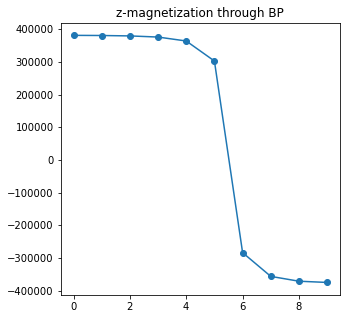

18 22
4 8
(40, 40, 10, 3)
(4, 4, 4, 3)


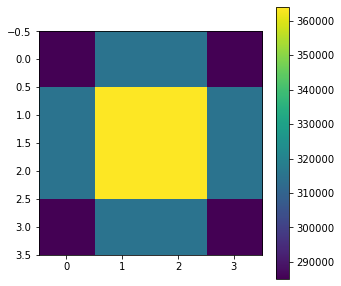

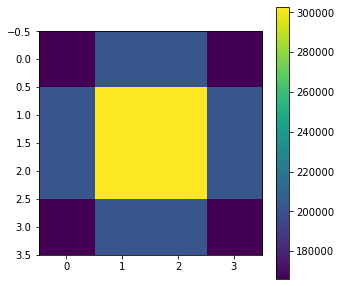

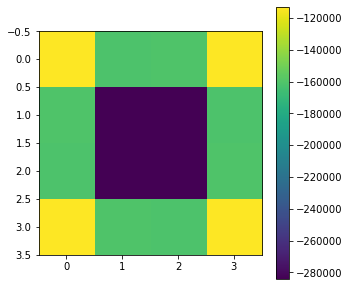

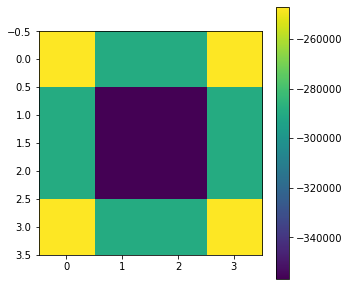

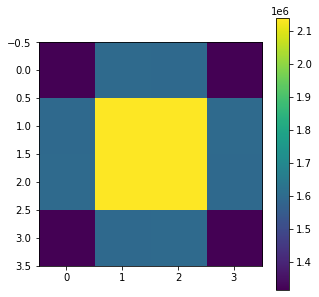

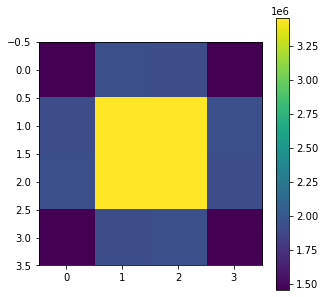

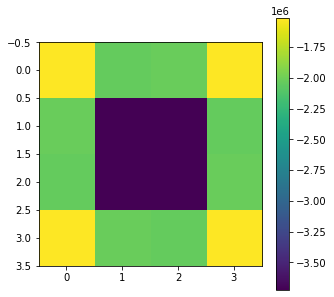

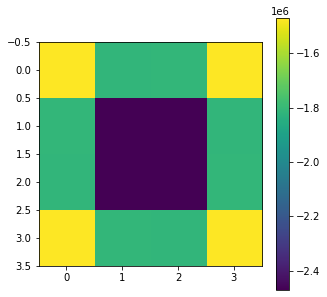

[   INFO] - LandauLifshitzGilbert module configuration:
[   INFO] -  - H_tot = H_stray + H_exch + H_dmi
[   INFO] -  - E_tot = E_stray + E_exch + E_dmi
[   INFO] -  - dM/dt = LLGE(M, H_tot)
[   INFO] - Performance hint: The number of cells nx, ny, nz in each direction should satisfy nx >= ny >= nz.
[   INFO] - Setting up demagnetization tensor field
[   INFO] -   Magn. size      : 80x80x20 cells
[   INFO] -   FFT size        : 160x160x40
[   INFO] -   PBC dimensions  : none  (1 repetitions)
[   INFO] -   Cache file      : /uni-mainz.de/homes/twinkler/.cache/magnum/Demag--80-80-20--160-160-40--1169-1169-1169.dat
[   INFO] -   0%


-3.4128004674772565e-19 1.0127545764434214e-18 2.5737105084934485e-20
d,  1.16975e-09


[   INFO] -   50%
[   INFO] -   100%
[   INFO] - Initialized modules: LandauLifshitzGilbert, StrayField, ExchangeField, DMIField
[   INFO] - Initializing material parameters
[   INFO] -   body id='disk', volume=100.0%, params: 'Ms=384000', 'alpha=0.28', 'A=8.78e-12'
[   INFO] - Runge Kutta evolver: method is rkf45, step size controller is MMM(eps_abs=0.001, eps_rel=0.0001).
[   INFO] - LandauLifshitzGilbert module configuration:
[   INFO] -  - H_tot = H_stray + H_exch + H_dmi
[   INFO] -  - E_tot = E_stray + E_exch + E_dmi
[   INFO] -  - dM/dt = LLGE(M, H_tot)
[   INFO] - Performance hint: The number of cells nx, ny, nz in each direction should satisfy nx >= ny >= nz.
[   INFO] - Setting up demagnetization tensor field
[   INFO] -   Magn. size      : 4x4x4 cells
[   INFO] -   FFT size        : 8x8x8
[   INFO] -   PBC dimensions  : none  (1 repetitions)
[   INFO] -   Cache file      : /uni-mainz.de/homes/twinkler/.cache/magnum/Demag--4-4-4--8-8-8--1169-1169-1169.dat
[   INFO] -   0%
[  

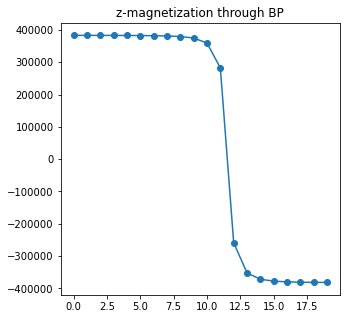

38 42
10 14
(80, 80, 20, 3)
(4, 4, 4, 3)


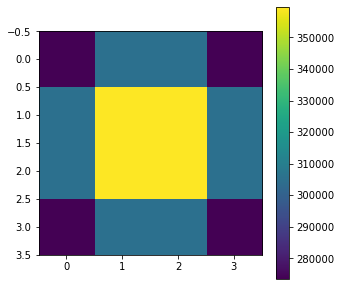

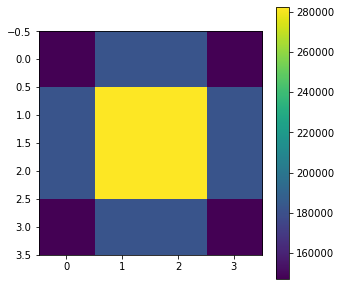

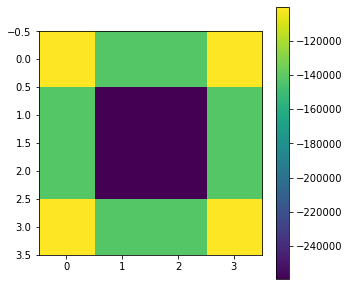

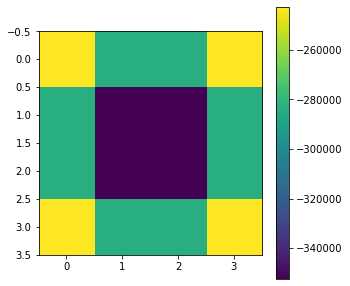

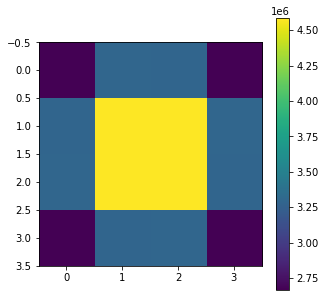

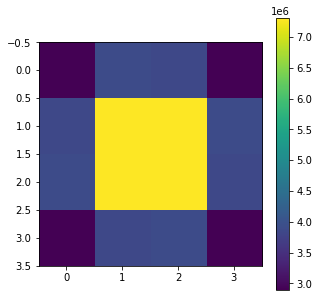

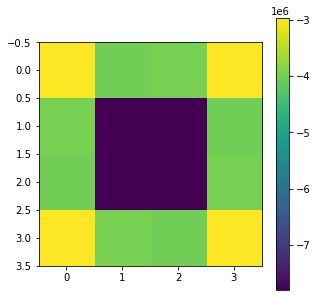

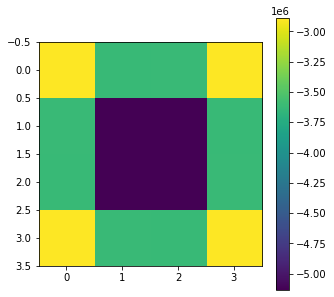

[   INFO] - LandauLifshitzGilbert module configuration:
[   INFO] -  - H_tot = H_stray + H_exch + H_dmi
[   INFO] -  - E_tot = E_stray + E_exch + E_dmi
[   INFO] -  - dM/dt = LLGE(M, H_tot)
[   INFO] - Performance hint: The number of cells nx, ny, nz in each direction should satisfy nx >= ny >= nz.
[   INFO] - Setting up demagnetization tensor field
[   INFO] -   Magn. size      : 120x120x30 cells
[   INFO] -   FFT size        : 240x240x60
[   INFO] -   PBC dimensions  : none  (1 repetitions)
[   INFO] -   Cache file      : /uni-mainz.de/homes/twinkler/.cache/magnum/Demag--120-120-30--240-240-60--779-779-779.dat
[   INFO] -   0%


-8.325987076198968e-20 5.024081642294022e-19 2.8411264952868674e-21
d,  7.798333333333333e-10


[   INFO] -   50%
[   INFO] -   100%
[   INFO] - Initialized modules: LandauLifshitzGilbert, StrayField, ExchangeField, DMIField
[   INFO] - Initializing material parameters
[   INFO] -   body id='disk', volume=100.0%, params: 'Ms=384000', 'alpha=0.28', 'A=8.78e-12'
[   INFO] - Runge Kutta evolver: method is rkf45, step size controller is MMM(eps_abs=0.001, eps_rel=0.0001).
[   INFO] - LandauLifshitzGilbert module configuration:
[   INFO] -  - H_tot = H_stray + H_exch + H_dmi
[   INFO] -  - E_tot = E_stray + E_exch + E_dmi
[   INFO] -  - dM/dt = LLGE(M, H_tot)
[   INFO] - Performance hint: The number of cells nx, ny, nz in each direction should satisfy nx >= ny >= nz.
[   INFO] - Setting up demagnetization tensor field
[   INFO] -   Magn. size      : 4x4x4 cells
[   INFO] -   FFT size        : 8x8x8
[   INFO] -   PBC dimensions  : none  (1 repetitions)
[   INFO] -   Cache file      : /uni-mainz.de/homes/twinkler/.cache/magnum/Demag--4-4-4--8-8-8--779-779-779.dat
[   INFO] -   0%
[   IN

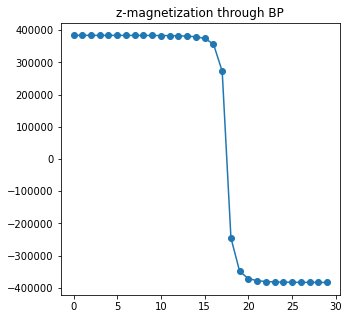

58 62
16 20
(120, 120, 30, 3)
(4, 4, 4, 3)


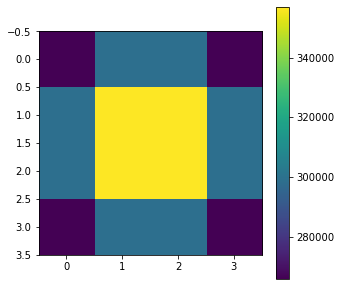

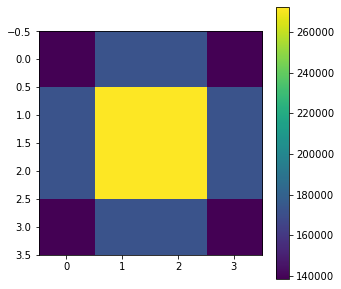

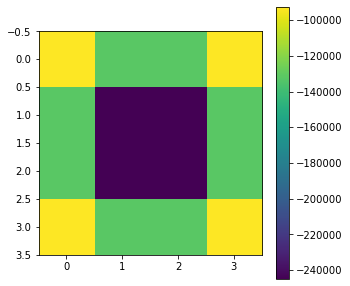

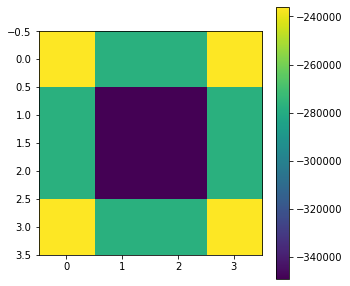

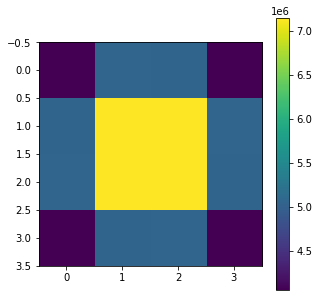

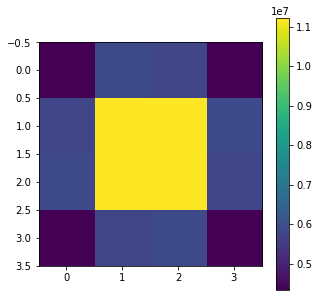

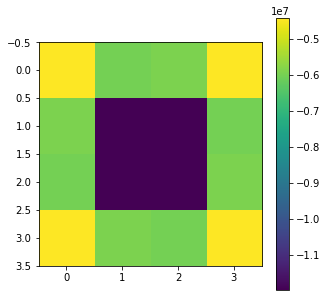

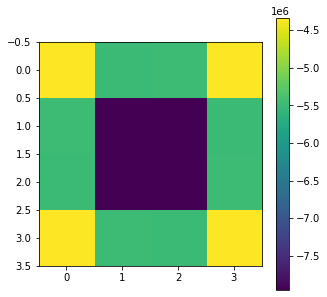

[   INFO] - LandauLifshitzGilbert module configuration:
[   INFO] -  - H_tot = H_stray + H_exch + H_dmi
[   INFO] -  - E_tot = E_stray + E_exch + E_dmi
[   INFO] -  - dM/dt = LLGE(M, H_tot)
[   INFO] - Performance hint: The number of cells nx, ny, nz in each direction should satisfy nx >= ny >= nz.
[   INFO] - Setting up demagnetization tensor field
[   INFO] -   Magn. size      : 160x160x40 cells
[   INFO] -   FFT size        : 320x320x80
[   INFO] -   PBC dimensions  : none  (1 repetitions)
[   INFO] -   Cache file      : /uni-mainz.de/homes/twinkler/.cache/magnum/Demag--160-160-40--320-320-80--584-584-584.dat
[   INFO] -   0%
[   INFO] -   50%


-3.6604924125232724e-20 3.340550762088487e-19 7.820116255297066e-22
d,  5.84875e-10


[   INFO] -   100%
[   INFO] - Initialized modules: LandauLifshitzGilbert, StrayField, ExchangeField, DMIField
[   INFO] - Initializing material parameters
[   INFO] -   body id='disk', volume=100.0%, params: 'Ms=384000', 'alpha=0.28', 'A=8.78e-12'
[   INFO] - Runge Kutta evolver: method is rkf45, step size controller is MMM(eps_abs=0.001, eps_rel=0.0001).
[   INFO] - LandauLifshitzGilbert module configuration:
[   INFO] -  - H_tot = H_stray + H_exch + H_dmi
[   INFO] -  - E_tot = E_stray + E_exch + E_dmi
[   INFO] -  - dM/dt = LLGE(M, H_tot)
[   INFO] - Performance hint: The number of cells nx, ny, nz in each direction should satisfy nx >= ny >= nz.
[   INFO] - Setting up demagnetization tensor field
[   INFO] -   Magn. size      : 4x4x4 cells
[   INFO] -   FFT size        : 8x8x8
[   INFO] -   PBC dimensions  : none  (1 repetitions)
[   INFO] -   Cache file      : /uni-mainz.de/homes/twinkler/.cache/magnum/Demag--4-4-4--8-8-8--584-584-584.dat
[   INFO] -   0%
[   INFO] -   50%
[   IN

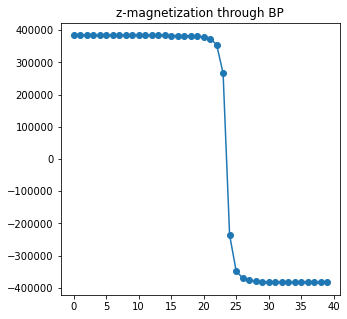

78 82
22 26
(160, 160, 40, 3)
(4, 4, 4, 3)


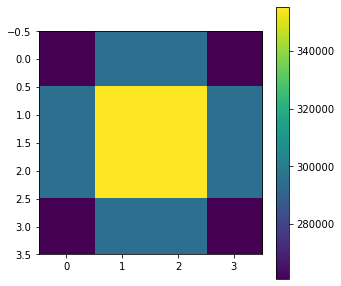

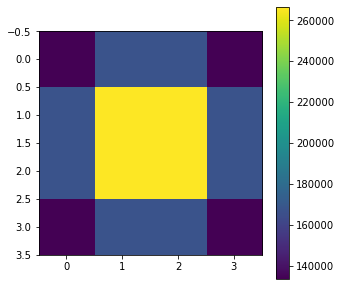

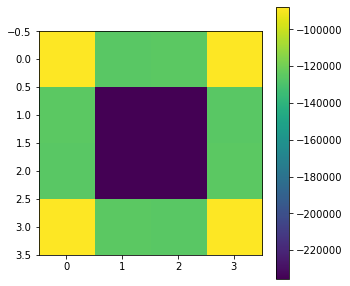

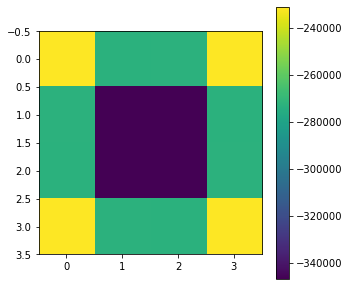

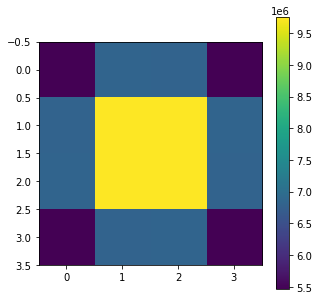

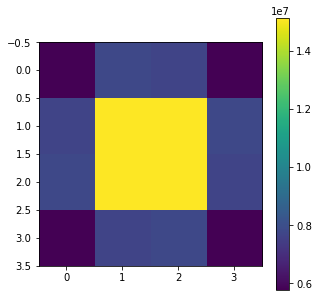

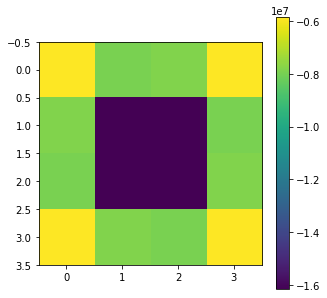

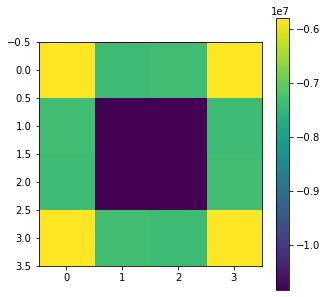

[   INFO] - LandauLifshitzGilbert module configuration:
[   INFO] -  - H_tot = H_stray + H_exch + H_dmi
[   INFO] -  - E_tot = E_stray + E_exch + E_dmi
[   INFO] -  - dM/dt = LLGE(M, H_tot)
[   INFO] - Performance hint: The number of cells nx, ny, nz in each direction should satisfy nx >= ny >= nz.
[   INFO] - Setting up demagnetization tensor field
[   INFO] -   Magn. size      : 200x200x50 cells
[   INFO] -   FFT size        : 400x400x100
[   INFO] -   PBC dimensions  : none  (1 repetitions)
[   INFO] -   Cache file      : /uni-mainz.de/homes/twinkler/.cache/magnum/Demag--200-200-50--400-400-100--467-467-467.dat
[   INFO] -   0%


-2.044832812610715e-20 2.502611780212491e-19 3.1435303075826046e-22
d,  4.679e-10


[   INFO] -   50%
[   INFO] -   100%
[   INFO] - Initialized modules: LandauLifshitzGilbert, StrayField, ExchangeField, DMIField
[   INFO] - Initializing material parameters
[   INFO] -   body id='disk', volume=100.0%, params: 'Ms=384000', 'alpha=0.28', 'A=8.78e-12'
[   INFO] - Runge Kutta evolver: method is rkf45, step size controller is MMM(eps_abs=0.001, eps_rel=0.0001).
[   INFO] - LandauLifshitzGilbert module configuration:
[   INFO] -  - H_tot = H_stray + H_exch + H_dmi
[   INFO] -  - E_tot = E_stray + E_exch + E_dmi
[   INFO] -  - dM/dt = LLGE(M, H_tot)
[   INFO] - Performance hint: The number of cells nx, ny, nz in each direction should satisfy nx >= ny >= nz.
[   INFO] - Setting up demagnetization tensor field
[   INFO] -   Magn. size      : 4x4x4 cells
[   INFO] -   FFT size        : 8x8x8
[   INFO] -   PBC dimensions  : none  (1 repetitions)
[   INFO] -   Cache file      : /uni-mainz.de/homes/twinkler/.cache/magnum/Demag--4-4-4--8-8-8--467-467-467.dat
[   INFO] -   0%
[   IN

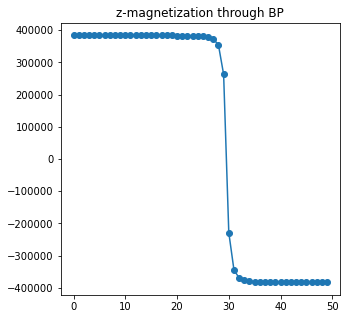

98 102
28 32
(200, 200, 50, 3)
(4, 4, 4, 3)


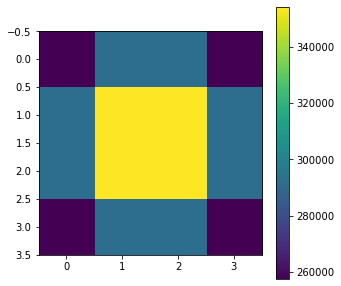

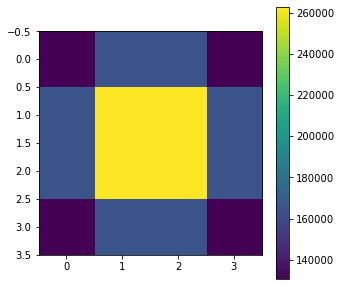

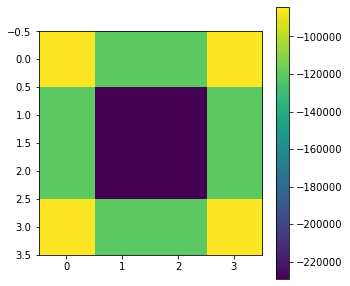

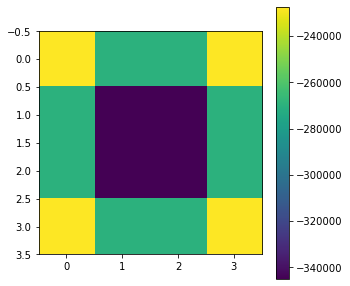

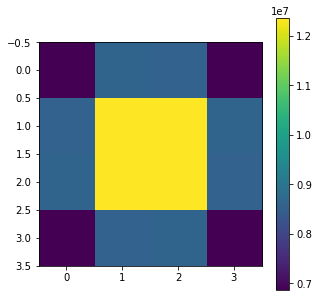

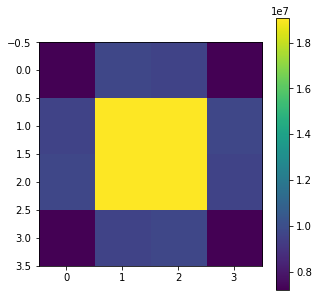

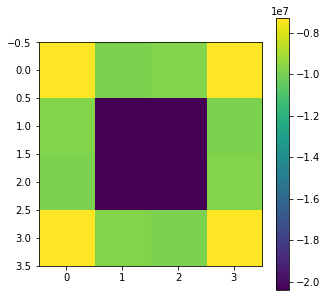

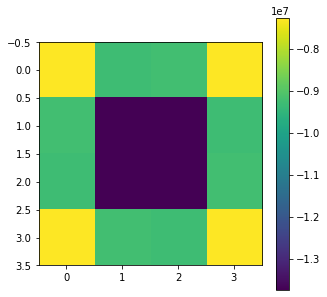

-1.3022502550240267e-20 2.0009750858487502e-19 1.5551395659611907e-22


In [6]:
##### system= "BP" #chossing configurations Bloch point (BP)
a=0.4679*1e-09 # lattice constant
system = "BP"
elistS = []
elistA = []
elistD = []

ntlist = [10, 20, 30, 40, 50]
dlist = [200*a/(4*n) for n in ntlist]
samplelist =["rectangular"]
for nt in ntlist: # thickness in units of FeGe lattice constant, chose nt=50 for HB model!
    for sample in samplelist:
        eAc, eSc,eDc,  = calc(nt, system, sample)
        elistS.append(eSc)
        elistA.append(eAc)
        elistD.append(eDc)

In [8]:
def lin(x,a):
    return a*x

def quad(x,a):
    return a*x**2
from scipy.optimize import curve_fit


poptA, pcovA = curve_fit(lin, dlist, elistA)
poptD, pcovD = curve_fit(quad, dlist, elistD)
print(poptA, pcovA)
print(poptD, pcovD)

[4.31613356e-10] [[9.26034012e-25]]
[-0.06222868] [[5.1272263e-08]]


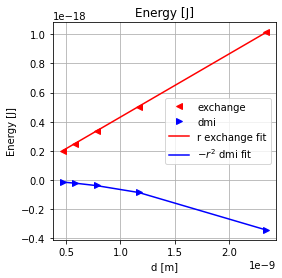

In [11]:
dlistn  = np.array(dlist)
elistSn = np.array(elistS)
elistAn = np.array(elistA)
elistDn = np.array(elistD) 

plt.figure(figsize=(4,4))
plt.title("Energy [J]")
plt.grid()
plt.ylabel("Energy [J]")
plt.xlabel("d [m]")
plt.plot(dlist,elistAn, "r<", label="exchange")
plt.plot(dlist, elistDn, "b>", label="dmi")
plt.plot(dlist,lin(dlistn, poptA), "r-", label="r exchange fit")
plt.plot(dlist, quad(dlistn, poptD), "b-", label=r"$-r^2$ dmi fit")
plt.legend()
plt.savefig("Figures/Fig_3_a.svg", dpi=300, bbox_inches="tight")
plt.show()